In [0]:
# required imports
import sys 
from collections import OrderedDict
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
# project_path = '~/.pytorch/CIFAR10_data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
project_path = '/content/drive/My Drive/cifar10/'

In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=False,
                                        download=True, transform=transform_test)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car truck truck  deer


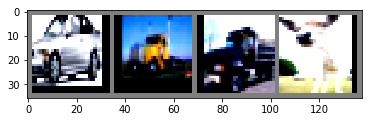

In [0]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [6]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 16

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!

class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
                
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x


In [0]:
target_model = CNN()
target_model = target_model.to(device)

In [0]:
# initalize a target model and train it

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(target_model.parameters(), lr=0.01)

target_model.train()

# let the magic begin
for epoch in range(30):  

    running_loss = 0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = target_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        optimizer.step()
        
        running_loss += loss.item()            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, running_loss / len(iter(target_train_loader))))
        
        

print('Finished Training the Target model...')

In [0]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %




---



In [0]:
torch.save(target_model.state_dict(), 'target_checkpoint.pth')

In [10]:
state_dict = torch.load('/content/drive/My Drive/saved_models/target_checkpoint.pth')
target_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
shadow_model = CNN()
shadow_model = shadow_model.to(device)

In [0]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.SGD(shadow_model.parameters(), lr=0.005)

# let the magic begin
for epoch in range(20):  

    running_loss = 0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        shadow_optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = shadow_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        shadow_optimizer.step()
        
        running_loss += loss.item()
            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, running_loss / len(iter(shadow_train_loader))))

print('Finished Training the Shadow model')

Epoch 0 loss 0.7218988392353057
Epoch 1 loss 0.7017893184566498
Epoch 2 loss 0.6660919382667542
Epoch 3 loss 0.636963704175949
Epoch 4 loss 0.6180133372497558
Epoch 5 loss 0.593347237815857
Epoch 6 loss 0.5728683202552796
Epoch 7 loss 0.5489865449619293
Epoch 8 loss 0.539557579612732
Epoch 9 loss 0.5229657737636566
Epoch 10 loss 0.502370139465332
Epoch 11 loss 0.48548810649871826
Epoch 12 loss 0.4652671359825134
Epoch 13 loss 0.44735063875198366
Epoch 14 loss 0.43587500834465026
Epoch 15 loss 0.4189693174648285
Epoch 16 loss 0.4103548542881012
Epoch 17 loss 0.3985494540500641
Epoch 18 loss 0.37525907807350156
Epoch 19 loss 0.36413238699913025
Finished Training the Shadow model


In [0]:
torch.save(shadow_model.state_dict(), 'shadow_checkpoint_1.pth')

In [12]:
state_dict = torch.load('/content/drive/My Drive/saved_models/shadow_checkpoint_1.pth')
shadow_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
# calculate the accuracy of the Shadow Model
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [0]:
# freeze the Shadow model 
shadow_model.eval()

for param in shadow_model.parameters():
  param.requires_grad = False

# make predictions on both datasets (shadow_in and shdow_out)
shadow_data = []

for inputs, labels in shadow_train_loader:
  inputs = inputs.to(device)  
    
#   predictions = shadow_model(inputs)
  predictions = F.log_softmax(shadow_model(inputs), dim=1)
   
  for i in range(predictions.shape[0]):
    shadow_data.append((predictions[i].sort(dim=0, descending=True)[0], 1))
#     shadow_data.append((predictions[i], 1))
  
for inputs, labels in shadow_out_loader:
  inputs = inputs.to(device)
  
#   predictions = shadow_model(inputs)
  predictions = F.log_softmax(shadow_model(inputs), dim=1)
  
  for i in range(predictions.shape[0]):
    shadow_data.append((predictions[i].sort(dim=0, descending=True)[0], 0))
#     shadow_data.append((predictions[i], 0))

# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together


In [0]:
# Create attack dataloader
attack_train_loader = torch.utils.data.DataLoader(shadow_data, batch_size=4, shuffle=True)

In [60]:
attack_model = nn.Sequential(nn.Linear(10, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 2),
                      nn.Softmax(dim=1))

attack_model.to(device)

Sequential(
  (0): Linear(in_features=10, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax()
)

In [65]:
# Make sure input looks right
inputs, labels = iter(attack_train_loader).next()
print(inputs[0].data.cpu().numpy())
print(labels[0])

[-3.4141541e-04 -7.9959383e+00 -1.2365501e+01 -1.5110296e+01
 -1.8584019e+01 -1.9393490e+01 -1.9635147e+01 -2.0528198e+01
 -2.1881422e+01 -2.2471889e+01]
tensor(0)


In [0]:
state_dict = torch.load('/content/drive/My Drive/saved_models/attack_checkpoint.pth')
attack_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1

# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

criterion = nn.CrossEntropyLoss()
attack_opt = optim.Adam(attack_model.parameters(), lr=0.05)

# let the magic begin
for epoch in range(20):  

    running_loss = 0
    
    for i, data in enumerate(attack_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
                
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        attack_opt.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = attack_model(inputs)
                
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        attack_opt.step()
        
        running_loss += loss.item()
            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, running_loss / len(iter(attack_train_loader))))
    
print('Finished Training the Shadow model')

Epoch 0 loss 0.8132616281509399
Epoch 1 loss 0.8132616281509399
Epoch 2 loss 0.8132616281509399
Epoch 3 loss 0.8132616281509399


KeyboardInterrupt: ignored

In [0]:
torch.save(attack_model.state_dict(), 'attack_checkpoint_1.pth')

In [0]:
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


# Run attack agains the target model
actual_value = []
pred_value = []

attack_model.eval()

for param in attack_model.parameters():
  param.requires_grad = False

for inputs, labels in target_train_loader:
  inputs = inputs.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(1)
    
for inputs, labels in target_out_loader:
  inputs = inputs.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(0)


In [35]:
# Calculate recall and precision
# precison = true positive / true positive + false positive
true_pos = 0
false_neg = 0

total_positive = sum(pred_value)
for i in range(len(actual_value)):
  if (pred_value[i] == 1) and (actual_value[i] == 1):
    true_pos += 1
  elif (pred_value[i] == 0) and (actual_value[i] == 1):
    false_neg += 1
    
print('True positive: {} Total Positive: {} Precision: {}'.format(true_pos, total_positive, true_pos / total_positive))
print('Recall: {}'.format(true_pos / (true_pos + false_neg)))

True positive: 7120 Total Positive: 14196 Precision: 0.501549732318963
Recall: 0.5696


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?

# Assignment 1
Carry out membership inference attack on a model whose architecture is unknown. The target model will be the same CNN from the ICP. The shadow model will be resnet18 with a Fully Connected head for CIFAR-10 classification

#Shadow Model Definition and Training

In [0]:
# pull down pretrained model
shadow_model = torchvision.models.resnet18(pretrained=True)

# Freeze convolutional layers
for param in shadow_model.parameters():
    param.requires_grad = False
    
shadow_model.fc = nn.Linear(512, 10)

shadow_model = shadow_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 110983261.97it/s]


In [0]:
# create transforms to load the images
cifar10_mean = [0.4915, 0.4823, 0.4468]
cifar10_std  = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

transform_test = transform
transform_train = transform

In [0]:
batch_size = 16

shadow_train_set = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)
# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(shadow_train_set, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(shadow_train_set, batch_size=batch_size, sampler=shadow_out_sampler)

Files already downloaded and verified


In [0]:
# Train model
optimizer = optim.SGD(shadow_model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 20

for epoch in range(epochs):  
    running_loss = 0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = shadow_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        optimizer.step()
        
        running_loss += loss.item()            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, running_loss / len(iter(shadow_train_loader))))

print('Finished Training the Shadow model')

Epoch 0 loss 1.851427352794296
Epoch 1 loss 1.3047815850171287
Epoch 2 loss 1.10060143653694
Epoch 3 loss 0.9908403562157965
Epoch 4 loss 0.9274591654158004
Epoch 5 loss 0.8791889847849336
Epoch 6 loss 0.8438573120652563
Epoch 7 loss 0.821930570294485
Epoch 8 loss 0.7992521979848443
Epoch 9 loss 0.7857093333512011
Epoch 10 loss 0.7703799887005326
Epoch 11 loss 0.7577778272464147
Epoch 12 loss 0.7458517409079825
Epoch 13 loss 0.7357047093112755
Epoch 14 loss 0.7273708373460623
Epoch 15 loss 0.7260105275665708
Epoch 16 loss 0.7082978080758049
Epoch 17 loss 0.7049631125786725
Epoch 18 loss 0.7041282978318536
Epoch 19 loss 0.6975781544090232
Finished Training the Shadow model


In [0]:
# calculate the accuracy of the Shadow Model
correct = 0
total = 0

with torch.no_grad():
    for data in shadow_out_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 74 %


In [0]:
torch.save(shadow_model.state_dict(), 'shadow_checkpoint_2.pth')

In [0]:
state_dict = torch.load('/content/drive/My Drive/saved_models/shadow_checkpoint_2.pth')
shadow_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#Define and Train Attack Model


1.   Generate attack model training data
2.   Define attack model
3.   Train model



In [0]:
# Create helper to generate attack data
def generate_attack_data(shadow_model, in_data, out_data):
  # freeze the Shadow model 
  shadow_model.eval()

  for param in shadow_model.parameters():
    param.requires_grad = False

  # make predictions on both datasets (shadow_in and shdow_out)
  attack_data = []

  for inputs, labels in in_data:
    inputs = inputs.to(device)  

    predictions = shadow_model(inputs)
  #   predictions = F.softmax(shadow_model(inputs), dim=1)

    for i in range(predictions.shape[0]):
      attack_data.append((predictions[i], 1))

  for inputs, labels in out_data:
    inputs = inputs.to(device)

    predictions = shadow_model(inputs)
  #   predictions = F.softmax(shadow_model(inputs), dim=1)

    for i in range(predictions.shape[0]):
      attack_data.append((predictions[i], 0))
      
  return attack_data

In [0]:
# Set up attack train data
attack_data = generate_attack_data(shadow_model, shadow_train_loader, shadow_out_loader)

In [0]:
attack_train_loader = torch.utils.data.DataLoader(attack_data, batch_size=32, shuffle=True)

In [0]:
# Define attack model
attack_model = nn.Sequential(nn.Linear(10, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 2))

attack_model.to(device)

Sequential(
  (0): Linear(in_features=10, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)

In [0]:
# Train model
optimizer = optim.SGD(attack_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 100

for epoch in range(epochs):  
    running_loss = 0
    
    for i, data in enumerate(attack_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = attack_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        optimizer.step()
        
        running_loss += loss.item()            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, running_loss / len(iter(attack_train_loader))))

print('Finished Training the Attack model')

In [0]:
torch.save(attack_model.state_dict(), 'attack_checkpoint.pth')

In [0]:
state_dict = torch.load('attack_checkpoint.pth')
attack_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#Results

In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


# Run attack agains the target model
actual_value = []
pred_value = []

attack_model.eval()

for param in attack_model.parameters():
  param.requires_grad = False

for inputs, labels in target_train_loader:
  inputs = inputs.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(1)
    
for inputs, labels in target_out_loader:
  inputs = inputs.to(device)
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(0)

In [0]:
# Calculate recall and precision
# precison = true positive / true positive + false positive
true_pos = 0
false_neg = 0

total_positive = sum(pred_value)
for i in range(len(actual_value)):
  if (pred_value[i] == 1) and (actual_value[i] == 1):
    true_pos += 1
  elif (pred_value[i] == 0 and actual_value[i] == 1):
    false_neg += 1
    
print('True positive: {} Total Positive: {} Precision: {}'.format(true_pos, total_positive, true_pos / total_positive))
print('Recall: {}'.format(true_pos / (true_pos + false_neg)))

True positive: 3504 Total Positive: 7456 Precision: 0.4699570815450644
Recall: 0.28032
